# Earth

In [0]:
!pip install -U -q netcdf4 xarray pytype google-cloud-storage pyresample

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import urllib
import xarray

import google.cloud.storage as gcs

from google.colab import auth
auth.authenticate_user()

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

IR_SCALE_FACTOR = [
    1e-2,  # 0
    1e-2,  # 1
    1e-2,  # 2
    1e-2,  # 3
    1e-2,  # 4
    1e-2,  # 5
    1e-2,  # 6
    1e-2,  # 7
    1 / 10, # 8
    1 / 20,  # 9
    1 / 30,  # 10
    1 / 100,  # 11
    1 / 100,  # 12
    1 / 150,  # 13
    1 / 150,  # 14
    1 / 150,  # 15
    1 / 150,  # 16
]

In [0]:
@contextmanager
def mktemp(**keyword_params):
  """Create a local file, removing it when the operation is complete.

  Args:
    **keyword_params: keyword params to be passed to tempfile.mkstemp().

  Yields:
    Filename of the temporary file.
  """

  fd, local_filename = tempfile.mkstemp(**keyword_params)
  os.close(fd)
  yield local_filename
  os.remove(local_filename)

In [0]:
FILE_REGEX = (r'.*/OR_([^/]+)-M(\d+)C(\d\d)_G\d\d_s(\d+)(\d)'
              r'_e(\d+)(\d)_c(\d+)(\d)[.]nc')

GoesFile = collections.namedtuple('GoesFile', [
    'path', 'product', 'mode', 'channel',
    'start_date', 'end_date', 'creation_date'
])

def _parse_filename(filename: Text) -> GoesFile:
    """Convert a filename to a GoesFile description.

    Args:
      filename: string name of the file

    Returns:
      A GoesFile tuple corresponding to the filename

    Raises:
      ValueError: if the filename does not have the expected format.
    """
    m = re.match(FILE_REGEX, filename)
    if not m:
      raise ValueError(
          'Goes filename does not match regular expression: ' + filename)
    product = m.group(1)
    mode = int(m.group(2))
    channel = int(m.group(3))
    start_date = datetime.datetime.strptime(m.group(4), '%Y%j%H%M%S')
    start_date += datetime.timedelta(milliseconds=100 * int(m.group(5)))
    start_date = start_date.replace(tzinfo=UTC)
    end_date = datetime.datetime.strptime(m.group(6), '%Y%j%H%M%S')
    end_date += datetime.timedelta(milliseconds=100 * int(m.group(7)))
    end_date = end_date.replace(tzinfo=UTC)
    creation_date = datetime.datetime.strptime(m.group(8), '%Y%j%H%M%S')
    creation_date += datetime.timedelta(milliseconds=100 * int(m.group(9)))
    creation_date = creation_date.replace(tzinfo=UTC)
    return GoesFile(filename, product, mode, channel, start_date, end_date,
                    creation_date)
  
def resample_world_img(
    world_img: np.ndarray,
    new_grid: pyresample.geometry.AreaDefinition) -> np.ndarray:
  """Resample an image of the world to fit a pyresample area.

  Args:
    world_img: a flat image with lat/lng extent (-180, 180, 90, -90).
    new_grid: the desired resampling grid.

  Returns:
    A resampled image.
  """
  h, w = world_img.shape[:2]
  lats = np.linspace(90, -90, h)
  lons = np.linspace(-180, 180, w)
  mesh_lons, mesh_lats = np.meshgrid(lons, lats)
  base_grid = pyresample.geometry.GridDefinition(
      lons=mesh_lons, lats=mesh_lats)
  return pyresample.kd_tree.resample_nearest(
      base_grid, world_img, new_grid,
      radius_of_influence=50000)

In [0]:
class GoesReader(object):
  """Client for accessing GOES-16 data."""

  def __init__(self, project_id: Text, goes_bucket_name: Text = GOES_BUCKET, key: Text = 'Rad', shape: Tuple[int, int] = (512, 512)):
    """Create a GoesReader.
    
    Args:
      project_id: the GCS project ID (for billing)
      goes_bucket_name: the GCS GOES bucket name (defaults to GOES-16)
      key: the data field (default 'Rad')
      shape: desired image shape
    """
    self.project_id = project_id
    self.goes_bucket_name = goes_bucket_name
    self.client = gcs.Client(project=project_id)
    self.tmp_dir = tempfile.mkdtemp('GoesReader')
    self.key = key
    self.shape = shape
    self.cache = {}
    self.world_imgs = {}

  def list_time_range(
      self, start_time: datetime.datetime, end_time: datetime.datetime) -> List[Tuple[datetime.datetime, Dict[int, gcs.Blob]]]:
    """List the blobs for GOES images within the given time range.

    Args:
      start_time: the beginning of the time range.
      end_time: the end of the time range.

    Returns:
      A list of time,channels pairs, where channels is a dictionary
      mapping channing number to GCS blob.
    """
    start_time = start_time.astimezone(UTC)
    end_time = end_time.astimezone(UTC)

    bucket = self.client.get_bucket(self.goes_bucket_name)
    blobs = []
    t = start_time
    h = datetime.timedelta(hours=1)
    while t < end_time + h:
      prefix = t.strftime('ABI-L1b-RadF/%Y/%j/%H')
      blobs.extend(bucket.list_blobs(prefix=prefix))
      t += h
      
    # Index them.
    channels = {}
    for b in blobs:
      f = _parse_filename(b.id)
      if f.start_date < start_time or f.start_date >= end_time:
        continue
      channel_map = channels.setdefault(f.start_date, {})
      channel_map[f.channel] = b
    return sorted(channels.items())
  
  def _resample_image(self, nc: xarray.DataArray) -> np.ndarray:
    """Extract an image from the GOES data."""
    kappa0 = nc['kappa0'].data
    if np.isnan(kappa0):
      kappa0 = IR_SCALE_FACTOR[nc.band_id.data[0]]
    img = nc[self.key].data
    img = img.astype(np.float32) * kappa0
    img = np.nan_to_num(img)
    img = np.minimum(1, np.maximum(0, img))
    img = skimage.transform.resize(img, self.shape, mode='reflect', anti_aliasing=True)
    return (img * 255).astype(np.uint8)
  
  def _load_image(self, blob: gcs.Blob) -> Tuple[np.ndarray, Dict[Text, Any]]:
    id = blob.id
    if id in self.cache:
      return self.cache[id]
    with mktemp(dir=self.tmp_dir, suffix='.nc') as infile:
      blob.download_to_filename(infile)
      with xarray.open_dataset(infile) as nc:
        img = self._resample_image(nc)
        md = {}
        for k in METADATA_KEYS:
          if k in nc.data_vars or k in nc.coords:
            md[k] = nc[k].copy()
        v = (img, md)
        self.cache[id] = v
        return v
      
  def load_channel_images(self, t: datetime.datetime, channels: List[int]) -> Dict[int, Tuple[np.ndarray, Dict[Text, Any]]]:
    blobs = self.list_time_range(t, t + datetime.timedelta(hours=1))
    t, channel_table = blobs[0]
    imgs = {}
    for c in channels:
      if c in channel_table:
        img, md = self._load_image(channel_table[c])
      else:
        img = np.zeros(self.shape, dtype=np.float32)
        md = {}
      imgs[c] = (img, md)
    return imgs
  
  def load_world_img_from_url(self, url: Text, grid: pyresample.geometry.AreaDefinition) -> np.ndarray:
    img = self.world_imgs.get(url)
    if img is None:
      with mktemp(dir=self.tmp_dir, suffix='.jpg') as infile:
        urllib.request.urlretrieve(url, infile)
        img = skimage.io.imread(infile)
        img = resample_world_img(img, grid)
        self.world_imgs[url] = img
    return img
  
reader = GoesReader(project_id=PROJECT_ID)

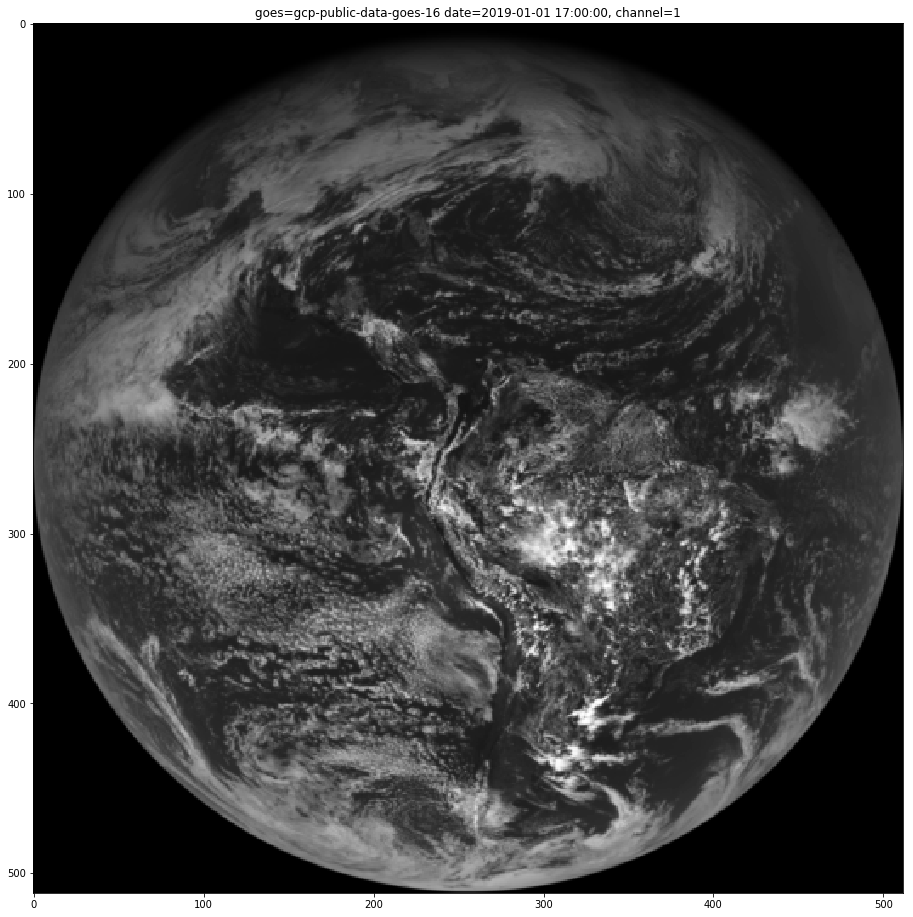

In [0]:
def show_channel_image(t: datetime.datetime, channel: int = 1, invert: bool = False):
  d = reader.load_channel_images(t, [channel])
  img, md = d[channel]
  plt.figure(figsize=(16, 16))
  if invert:
    img = 255 - img
  plt.imshow(img, cmap='gray')
  plt.title('goes={} date={}, channel={}'.format(reader.goes_bucket_name, t, channel))
  plt.show()
  
show_channel_image(datetime.datetime(2019, 1, 1, 17), channel=1)

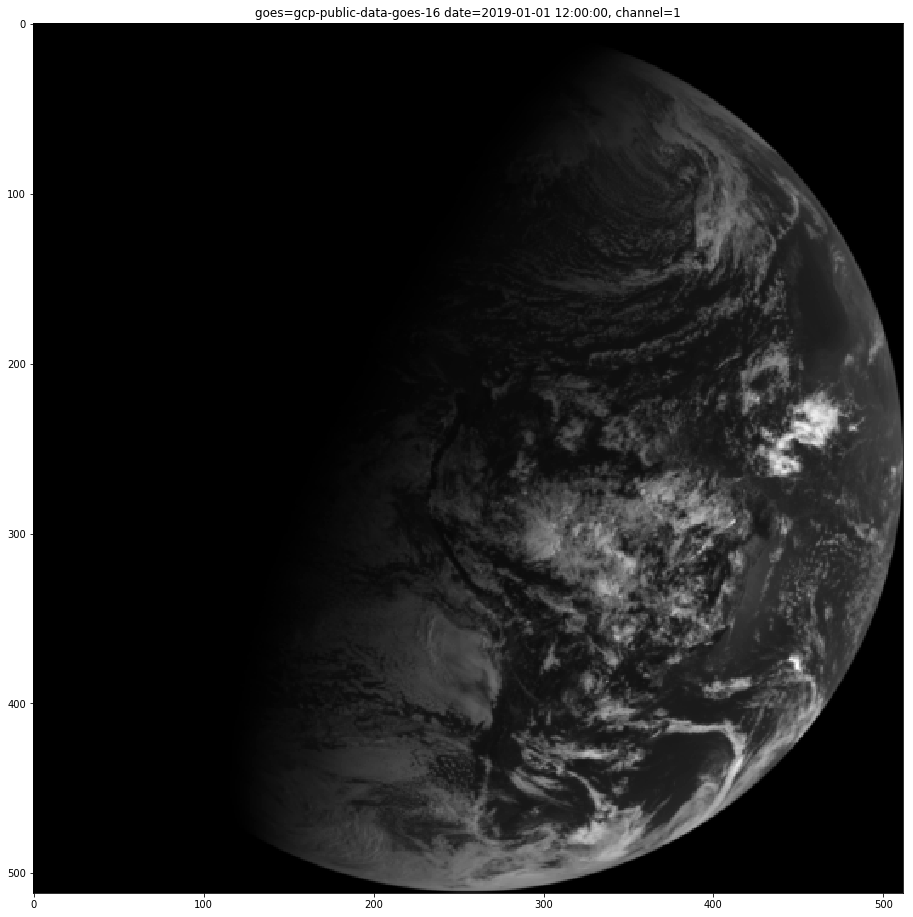

In [0]:
show_channel_image(datetime.datetime(2019, 1, 1, 12), channel=1)

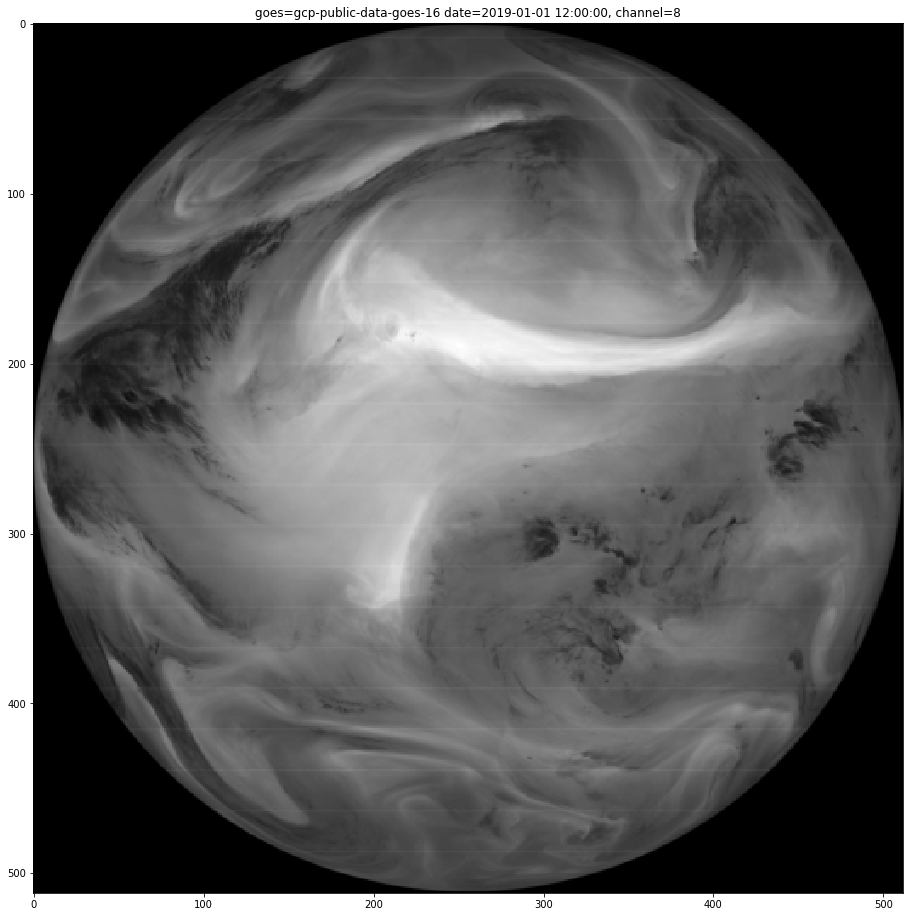

In [0]:
show_channel_image(datetime.datetime(2019, 1, 1, 12), channel=8)

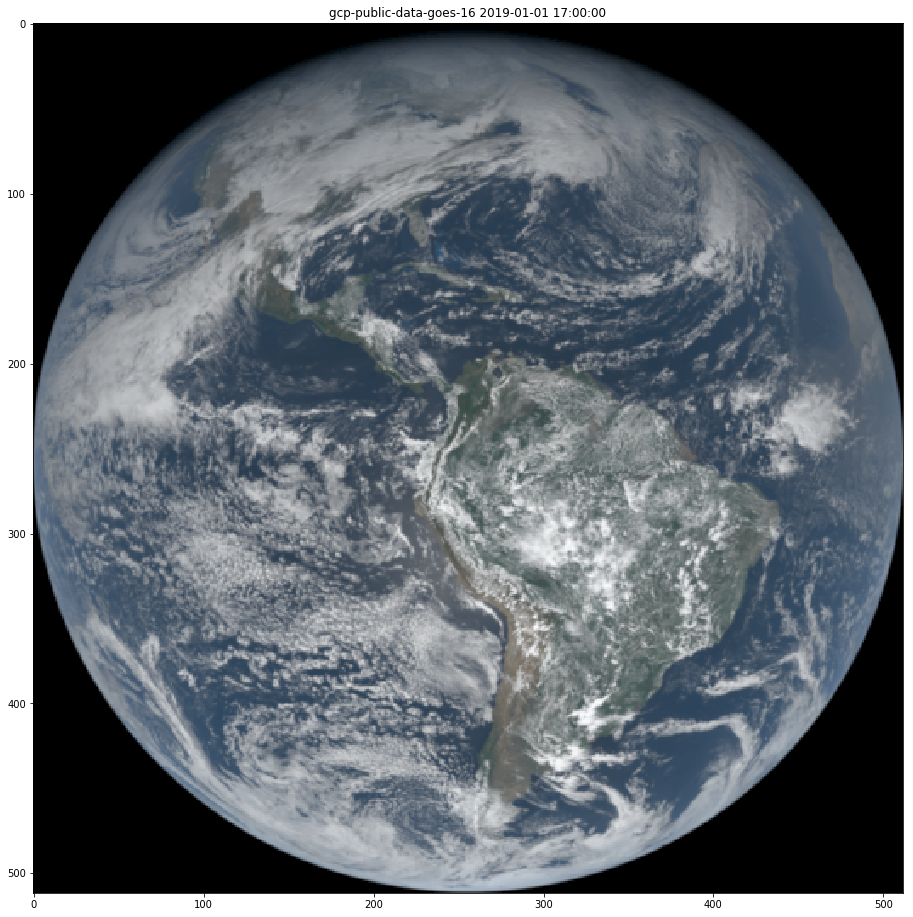

In [0]:
MAX_COLOR_VALUE = 255.9
MAX_PIXEL_VALUE = MAX_COLOR_VALUE / 256

def goes_to_daytime(ref: Dict[int, Tuple[np.ndarray, Any]]) -> np.ndarray:
  """Convert GOES channels to a truecolor image based on daytime channels.

  Args:
    ref: a dictionary of GOES channel images.

  Returns:
    A numpy RGB uint8 array with the truecolor image.
  """
  # Daytime image.
  blue, _ = ref[1]
  red, _ = ref[2]
  veggie, _ = ref[3]
  green = 0.45 * blue + 0.1 * veggie + 0.45 * red
  rgb = np.stack([red, green, blue], axis=-1)
  rgb = rgb.astype(np.float32) / 255

  # Gamma correction.
  rgb = np.sqrt(rgb)

  # Clipping.
  rgb = np.minimum(MAX_PIXEL_VALUE, np.maximum(0, rgb))
  return (rgb * 256).astype(np.uint8)


def show_daytime_image(t: datetime.datetime):
  imgs = reader.load_channel_images(t, [1, 2, 3])
  rgb = goes_to_daytime(imgs)
     
  plt.figure(figsize=(16, 16))
  plt.imshow(rgb)
  plt.title('{} {}'.format(reader.goes_bucket_name, t))
  plt.show()
  
show_daytime_image(datetime.datetime(2019, 1, 1, 17))  

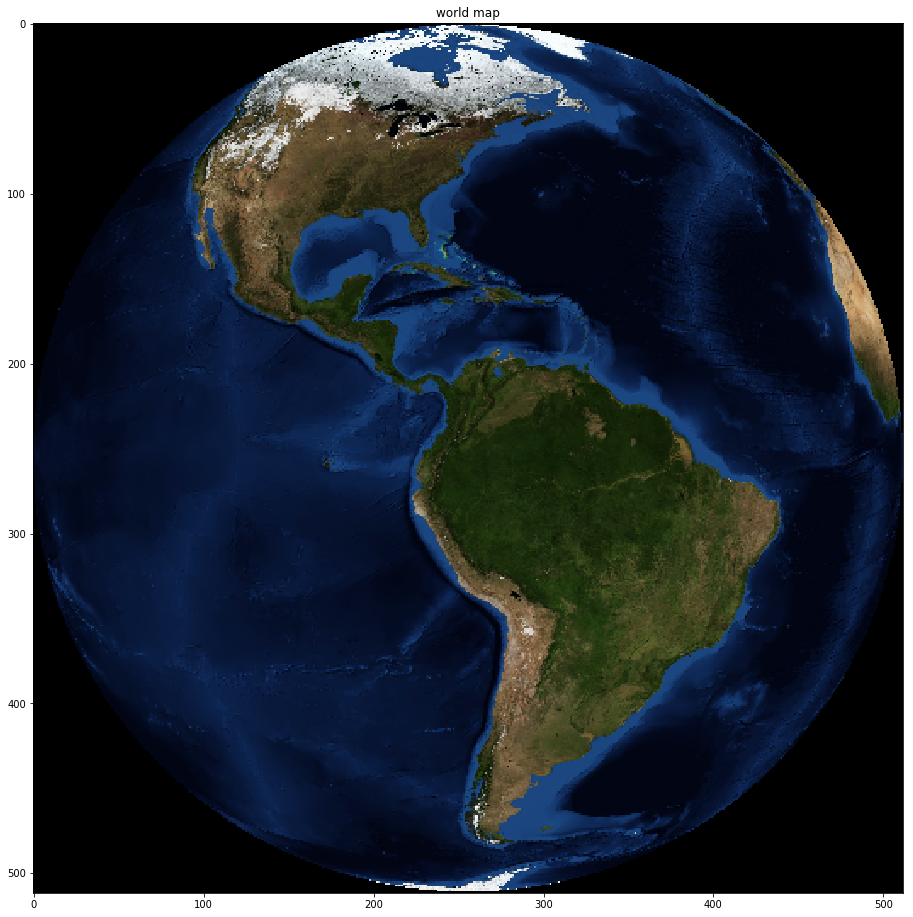

In [0]:
def goes_area_definition(md: Dict[Text, Any], shape: Optional[Tuple[int, int]] = None) -> pyresample.geometry.AreaDefinition:
  """Get the area definition for the satellite image.
  
  Args:
    md: the satellite metadata
    shape: optional shape override
    
  Returns:
    A pyresample AreaDefinition for the satellite projection.
  """
  # Dee the following references for GOES imager.
  #  Ref-1: https://proj4.org/usage/projections.html
  #  Ref-2: https://proj4.org/operations/projections/geos.html
  proj_lon_0 = md['goes_imager_projection'].longitude_of_projection_origin
  proj_h_0_m = md['goes_imager_projection'].perspective_point_height  # meters
  if shape is None:
    nx = md['x'].shape[0]
    ny = md['y'].shape[0]
  else:
    ny, nx = shape
  x1, x2 = md['x_image_bounds'].data * proj_h_0_m
  y2, y1 = md['y_image_bounds'].data * proj_h_0_m
  extents_m = [x1, y1, x2, y2]
  grid = pyresample.geometry.AreaDefinition(
    'geos',
    'goes_conus',
    'geos',
    { 'proj': 'geos',  # 'geostationary'
      'units': 'm',  # 'meters', the (same) unit for all measures here
      'h': str(proj_h_0_m),  # Ref-2, height of the view point above Earth
      'lon_0': str(proj_lon_0),  # Ref-2, longitude of the proj center
      'a': str(md['goes_imager_projection'].semi_major_axis),  # Ref-1
      'b': str(md['goes_imager_projection'].semi_minor_axis),  # Ref-1
      'sweep': str(md['goes_imager_projection'].sweep_angle_axis)  # Ref-2
    },
    nx,
    ny,
    extents_m)
  return grid

def show_world_map(t: datetime.datetime):
  imgs = reader.load_channel_images(t, [1])
  _, md = imgs[1]
  grid = goes_area_definition(md, shape=reader.shape)
  world_img = reader.load_world_img_from_url(BLUE_MARBLE, grid)
  plt.figure(figsize=(16, 16))
  plt.imshow(world_img)
  plt.title('world map')
  plt.show()
  
show_world_map(datetime.datetime(2019, 1, 1, 17))

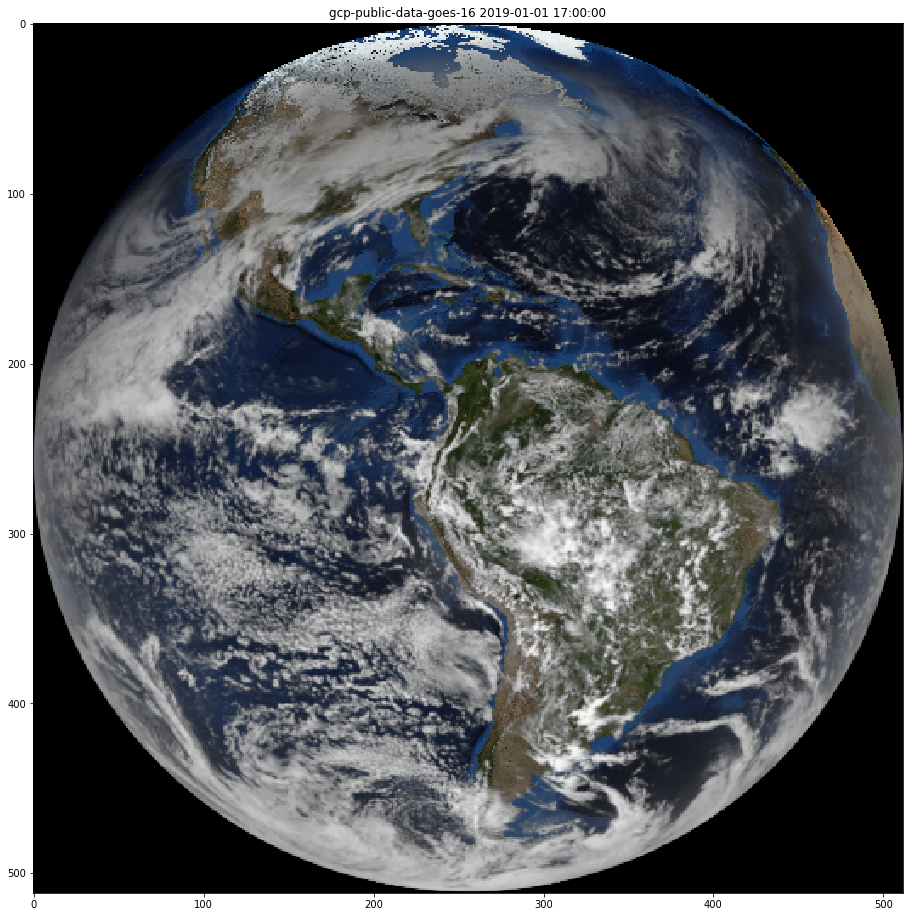

In [0]:
def cloud_mask(ref: Dict[int, Tuple[np.ndarray, Any]]) -> np.ndarray:
  """Convert GOES blue channel to a cloud mask.

  Args:
    ref: a dictionary of GOES channel images.

  Returns:
    A numpy uint8 array with the cloud mask.
  """
  blue, _ = ref[1]
  lum = np.sqrt(blue.astype(np.float32) / 256)
  mask = 1 / (1 + np.exp(-10 * (lum - 0.3)))
  return (lum * mask * MAX_COLOR_VALUE).astype(np.uint8)

def show_daytime_mask_image(t: datetime.datetime):
  ref = reader.load_channel_images(t, [1, 2, 3])
  blue, md = ref[1]
  grid = goes_area_definition(md, shape=reader.shape)
  world_img = reader.load_world_img_from_url(BLUE_MARBLE, grid)

  lum = cloud_mask(ref)
  lum = lum[:, :, np.newaxis]
  lum = lum.astype(np.float32) / 256
  mask = 1 / (1 + np.exp(-10 * (lum - 0.3)))
  world_img = world_img / 256
  img = lum * mask + (1 - mask) * world_img
     
  plt.figure(figsize=(16, 16))
  plt.imshow(img)
  plt.title('{} {}'.format(reader.goes_bucket_name, t))
  plt.show()
  
show_daytime_mask_image(datetime.datetime(2019, 1, 1, 17))  

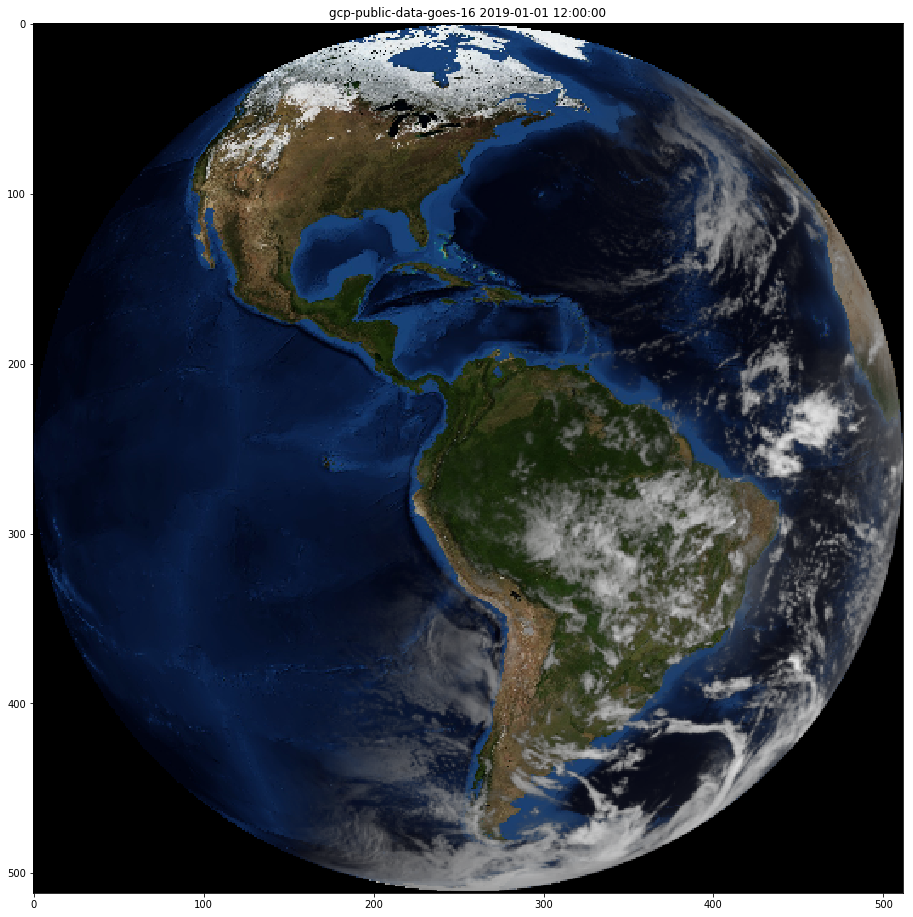

In [0]:
show_daytime_mask_image(datetime.datetime(2019, 1, 1, 12))  